<a href="https://colab.research.google.com/github/AlexBorealis/netology_cvml_hw/blob/master/kozlov_cvml_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Loading packages**

In [1]:
import cv2
from glob import glob
import numpy as np
import os
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.callbacks import (
        EarlyStopping, ModelCheckpoint, TensorBoard,
        ReduceLROnPlateau, CSVLogger)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

print(tf.__version__)
print(tf.executing_eagerly())

2.18.0
True


# **2. Unzip data**

In [2]:
!unzip dogs-vs-cats-redux-kernels-edition.zip
!unzip train.zip
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/55

# **3. Function for a work with model nn**

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 256

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return efficientnet_v2.preprocess_input(img)

def fit_generator(files, batch_size=BATCH_SIZE):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield (np.array([load_image(path)]),)

## **Vizualization data**

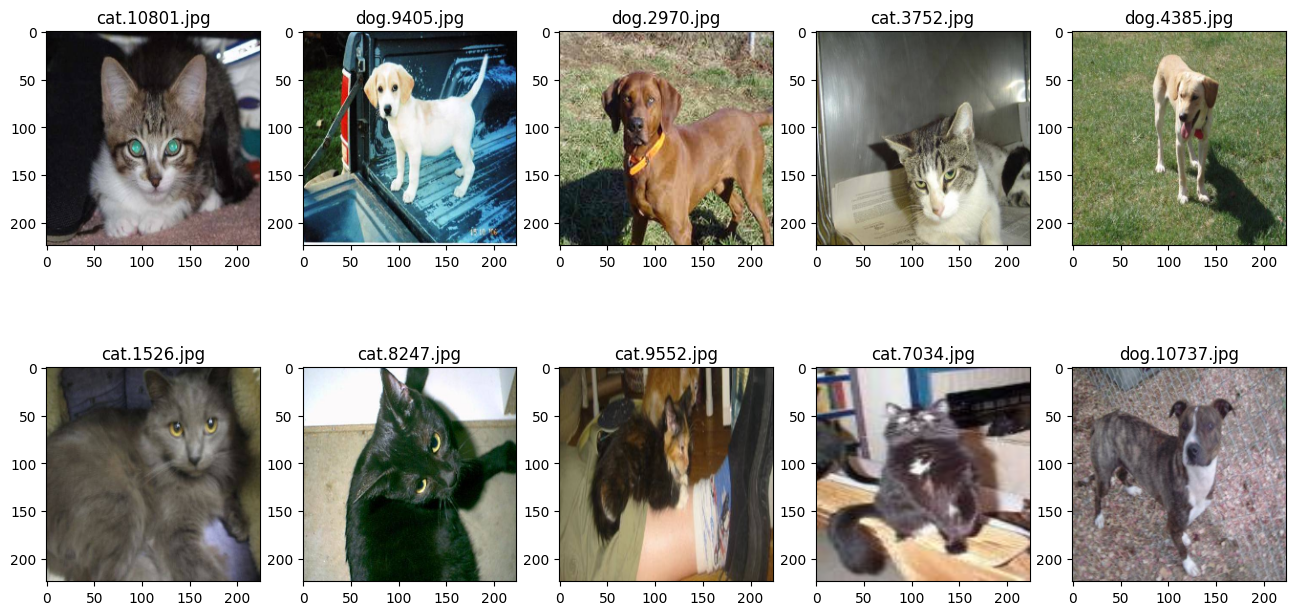

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[90:100], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

# **4. Loading pretrained model**

In [5]:
base_model = efficientnet_v2.EfficientNetV2S(weights='imagenet',
                                             include_top=False,
                                             input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
base_model.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

## **Addition fully connected layer**

In [9]:
len([l for l in base_model.layers])

513

In [11]:
base_model.trainable = False

x = base_model.layers[-51].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # for binary classification
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [12]:
model.summary()

Model: "dogs_vs_cats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 16,975,777 (64.76 MB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 16,963,232 (64.71 MB)

## **Compiling model**

In [13]:
model.compile(optimizer=SGD(nesterov=True, momentum=.1),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

## **Creation callbacks**

In [14]:
callbacks_ = [
    ModelCheckpoint(filepath= './EffNetV2S/EffNetV2S.logloss_{val_loss:.2f}-val_accuracy_{val_accuracy:.2f}-val_precision_{val_precision:.2f}-val_recall_{val_recall:.2f}.h5.keras',
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
    TensorBoard(log_dir= './logs_effnetv2s'),
    EarlyStopping(monitor= "loss", mode= 'min',
                  patience= 5, start_from_epoch= 10,
                  min_delta= .01, verbose= 1)
]

## **Creation train and validation data**

In [15]:
val_samples = 12

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

## **Fitting model**

In [16]:
history = model.fit(train_data,
                    steps_per_epoch=250,
                    epochs=30,
                    validation_data=validation_data,
                    callbacks=callbacks_)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 255ms/step - accuracy: 0.9665 - loss: 0.1032 - precision: 0.9640 - recall: 0.9701 - val_accuracy: 1.0000 - val_loss: 0.0143 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.9897 - loss: 0.0540 - precision: 0.9903 - recall: 0.9892 - val_accuracy: 1.0000 - val_loss: 0.0139 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.9922 - loss: 0.0398 - precision: 0.9917 - recall: 0.9926 - val_accuracy: 1.0000 - val_loss: 0.0145 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.9958 - loss: 0.0270 - precision: 0.9969 - recall: 0.9947 - val_accuracy: 1.0000 - val_loss: 0.0138 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.9954 - loss: 0.0266 - precision: 0.9951 - recall: 0.9958 - val_accuracy: 1.000

## **Prediction on test data**

In [17]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files)
    )

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 161s 12ms/step


# **5. Vizualization predicted data**

<ipython-input-18-a4b796aef3ea>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.0f %s' % (score, os.path.basename(path)))


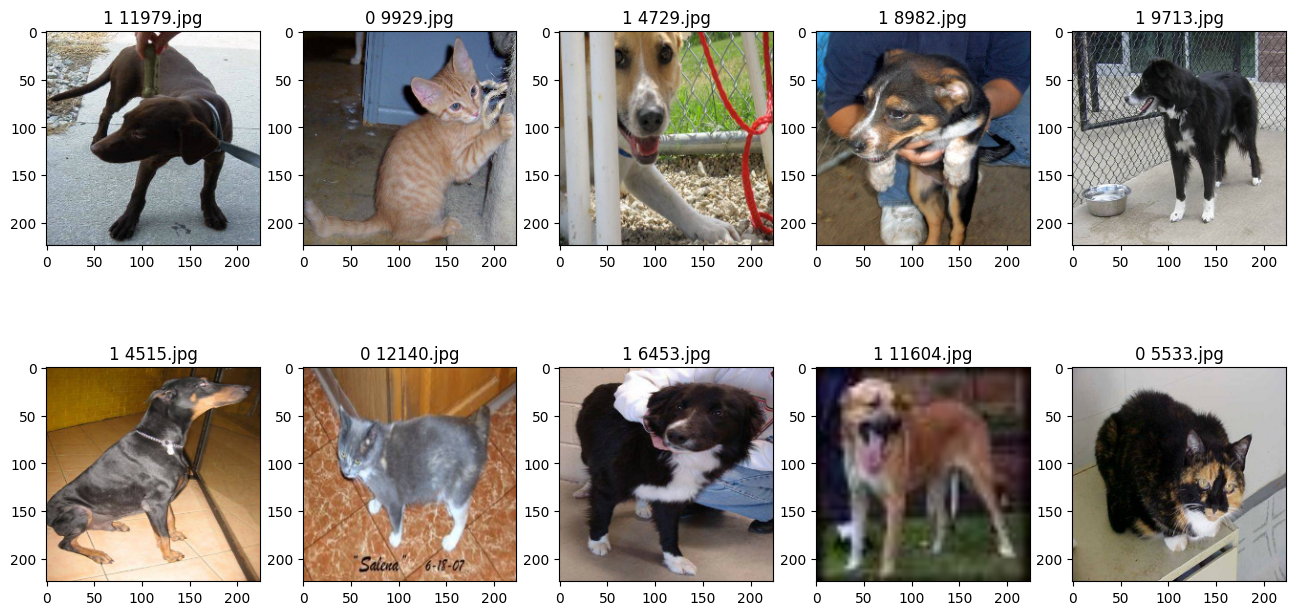

In [18]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.0f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

# **6. Creation file for sending to Kaggle**

In [19]:
import re

data = []

for path, score in zip(test_files, test_pred):
    id_value = re.search('(\d+).jpg$', path).group(1)
    data.append((int(id_value), score))

data.sort(key=lambda x: x[0])

with open('submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for id_value, score in data:
        dst.write('%0.f,%f\n' % (id_value, score))

<ipython-input-19-7d0dd1e6e442>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%0.f,%f\n' % (id_value, score))
